In [1]:
import os
import re
import json
from tqdm import tqdm

In [2]:
data_path = "/home/phani/cord-19_2020-04-10/2020-04-10/biorxiv_medrxiv/"
docs= []

num_files = 0
#num_corrupted = 0


In [3]:
for d in [ data_path + "pdf_json/" ]:
    print(f"Importing files from {d}")
    files = os.listdir(d)
    num_files += len(files)
    for file in tqdm(files):
        file_path = d + file
        
        try:
            j = json.load(open(file_path, "rb"))
        except:
            num_corrupted += 1
            #print(f"Erron: Could not open {file_path}")

        try:
            title = j["metadata"]["title"]
        except:
            title = ""

        try:
            abstract = j["abstract"][0]["text"]
        except:
            abstract = ""

        full_text = ""

        for text in j["body_text"]:
            full_text += text["text"] + "\n\n"

        docs.append([title, abstract, full_text])

  8%|▊         | 129/1625 [00:00<00:01, 1282.42it/s]

Importing files from /home/phani/cord-19_2020-04-10/2020-04-10/biorxiv_medrxiv/pdf_json/


100%|██████████| 1625/1625 [00:00<00:00, 1628.58it/s]


In [4]:
import pandas as pd
import nltk
import nltk.data
import statistics
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/phani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
sentence_detector = nltk.data.load('/home/phani/nltk_data/tokenizers/punkt/english.pickle')

In [7]:
df = pd.DataFrame(docs, columns=["title", "abstract", "full_text"])
docs = "" 

incubation = df[df["full_text"].str.contains("incubation")]

texts = incubation["full_text"].values

incubation_times = []

# Get incubation time from sentences like:
# "Furthermore, the mean incubation period for SARS-CoV-2 infection has been reported to be from 0 to 14 days."
print("Searching for incubation times in dataset.")
for text in tqdm(texts):
    for sentence in sentence_detector.tokenize(text):
        if "incubation" in sentence:
            time = re.findall(r" (\d{1,2}(?:\.\d{1,2})?)? ?(?:to|-) ?(\d{1,2}(?:\.\d{1,2})?) day", sentence)
            if len(time) == 1:
                if time[0][0] == "":
                    time = float(time[0][1])
                    if time <= 30:  # discard unrealistic data
                        incubation_times.append(time)
                else:
                    # when time is given as range, add all possible values
                    a = int(float(time[0][0]))  # first make float from str, then int
                    b = int(float(time[0][1]))
                    if b <= 30:  # discard unrealistic data
                        incubation_times += [*range(a, b+1)]

  3%|▎         | 13/417 [00:00<00:03, 123.42it/s]

Searching for incubation times in dataset.


100%|██████████| 417/417 [00:03<00:00, 123.55it/s]


In [8]:
import csv
with open("incubation_time.csv", "w", newline='') as f:
    w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
    w.writerow(incubation_times)

In [9]:
print(f"The mean projected incubation time is {statistics.mean(incubation_times):.2f} days.")


The mean projected incubation time is 7.95 days.


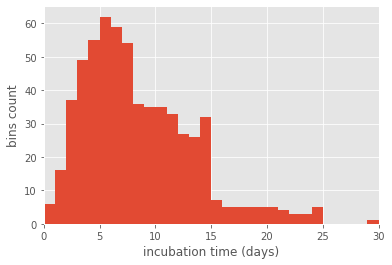

In [10]:
import matplotlib.pyplot as plt

from matplotlib import style

style.use("ggplot")


plt.hist(incubation_times, bins=30)
plt.ylabel("bins count")
plt.xlabel("incubation time (days)")
plt.xlim(0, 30)
plt.show()